In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.rcParams["figure.figsize"] = (9,6)

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv')
print(df.shape)
df.head()

(17420, 8)


,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000


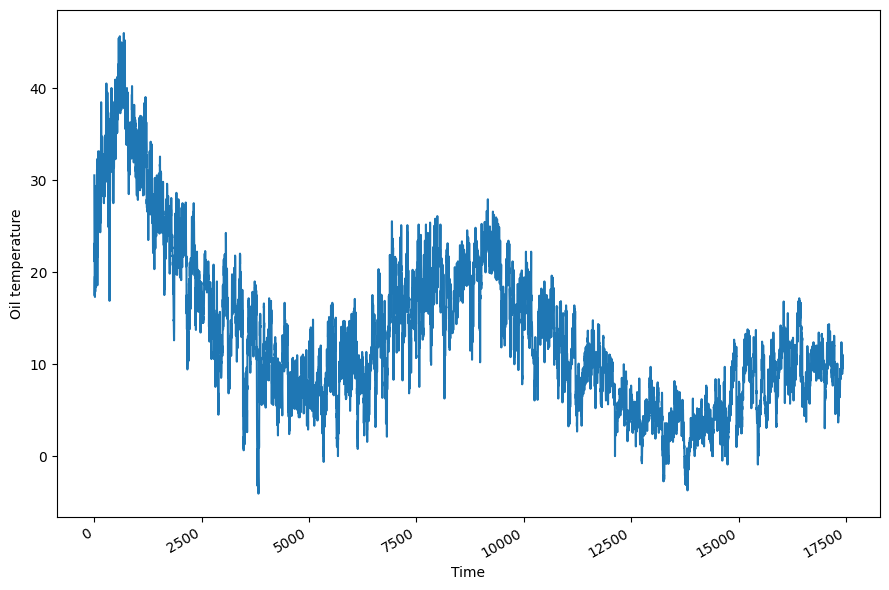

In [4]:
fig, ax = plt.subplots()

ax.plot(df['OT'])
ax.set_xlabel('Time')
ax.set_ylabel('Oil temperature')

fig.autofmt_xdate()
plt.tight_layout()

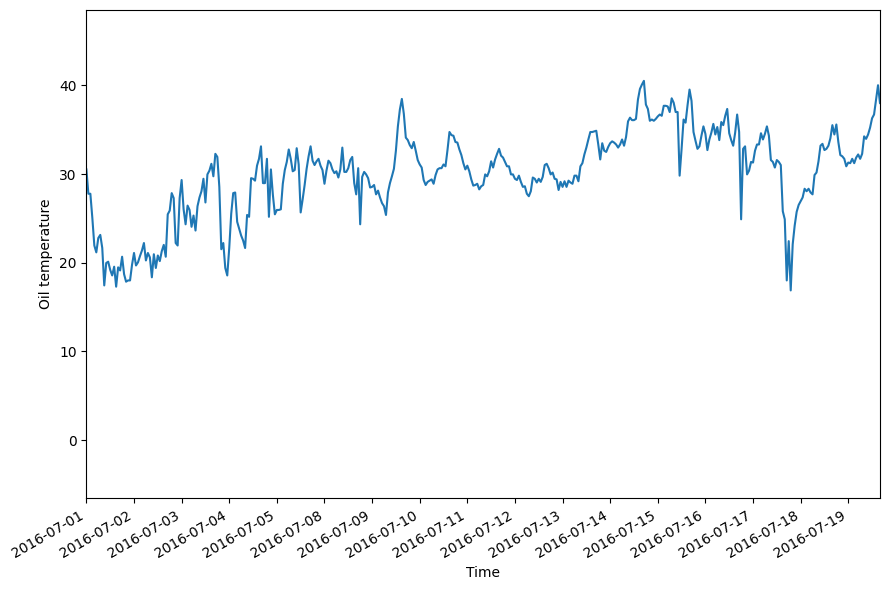

In [5]:
fig, ax = plt.subplots()

ax.plot(df['OT'])
ax.set_xlabel('Time')
ax.set_ylabel('Oil temperature')

plt.xticks(
    np.arange(0, 400, 24), 
    ['2016-07-01', '2016-07-02', '2016-07-03', '2016-07-04', '2016-07-05', '2016-07-08', '2016-07-09', '2016-07-10', '2016-07-11', '2016-07-12', '2016-07-13', '2016-07-14', '2016-07-15', '2016-07-16', '2016-07-17', '2016-07-18', '2016-07-19']
)
plt.xlim(0, 400)

fig.autofmt_xdate()
plt.tight_layout()

In [6]:
# Perform Fourier transform to identify seasonal periods
from tensorflow.signal import rfft

2024-04-08 12:15:04.929575: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


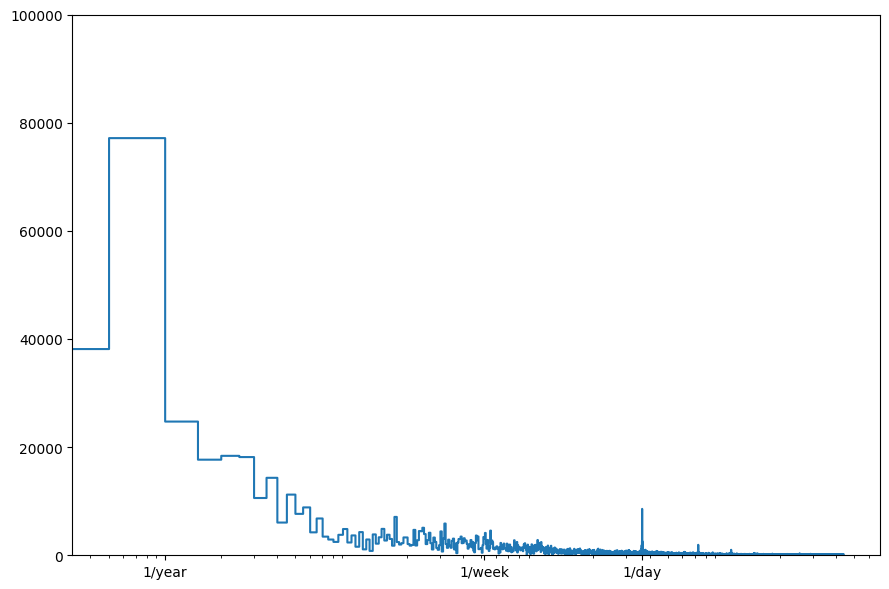

In [7]:
# Now perform Fourier transform
fft = rfft(df['OT'])

# find total len of data
f_per_dataset = np.arange(0, len(fft))

n_sample_h = len(df['OT'])

# Going to test hourly , weekly and yearly freqs
hours_per_week = 24 * 7
hours_per_year = 24 * 365.2524
weeks_per_dataset = n_sample_h / hours_per_week
years_per_dataset = n_sample_h / hours_per_year

f_per_year = f_per_dataset / years_per_dataset

plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.xticks([1, 52, 365.2524], ['1/year', '1/week', '1/day'])
plt.ylim(0, 100000)
plt.tight_layout()
plt.show()

In [8]:
# Encode seasonal periods
import datetime

# Convert our dt into seconds only
timestamp_s = pd.to_datetime(df['date']).map(datetime.datetime.timestamp)

day = 24*60*60
year = (365.2524) * day

# Encode our seasonal info using sin and cosine - convert into radians
df['day_sin'] = np.sin(timestamp_s * (2*np.pi / day))
df['day_cos'] = np.cos(timestamp_s * (2*np.pi / day))

df['year_sin'] = np.sin(timestamp_s * (2*np.pi / year))
df['year_cos'] = np.cos(timestamp_s * (2*np.pi / year))

In [9]:
# Take a look
df.head()

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT,day_sin,day_cos,year_sin,year_cos
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000,-2.588190e-01,0.965926,0.021987,-0.999758
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001,-4.877283e-12,1.000000,0.021271,-0.999774
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001,2.588190e-01,0.965926,0.020554,-0.999789
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001,5.000000e-01,0.866025,0.019838,-0.999803
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000,7.071068e-01,0.707107,0.019121,-0.999817


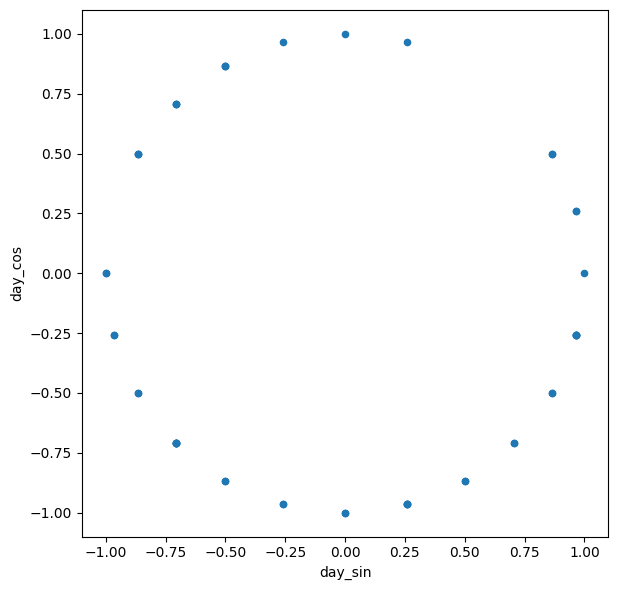

In [10]:
df.sample(50).plot.scatter('day_sin','day_cos').set_aspect('equal');
plt.tight_layout()

In [11]:
# Create train/validation/test sets
df = df.drop(['date'], axis=1)

# Get len of df
n = len(df)

# define
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(0.9 * n):]

print(train_df.shape, val_df.shape, test_df.shape)

(12194, 11) (3484, 11) (1742, 11)


In [12]:
# Get the min and max values of the targets (to be used in future lessons)

MULL_max_train = np.max(train_df['MULL'])
MULL_min_train = np.min(train_df['MULL'])
MULL_max_test = np.max(test_df['MULL'])
MULL_min_test = np.min(test_df['MULL'])

OT_max_train = np.max(train_df['OT'])
OT_min_train = np.min(train_df['OT'])
OT_max_test = np.max(test_df['OT'])
OT_min_test = np.min(test_df['OT'])

print(MULL_max_train, MULL_min_train, MULL_max_test, MULL_min_test)
print(OT_max_train, OT_min_train, OT_max_test, OT_min_test)

7.568999767303468 -5.934000015258789 4.690999984741211 -3.3399999141693115
46.00699996948242 -4.079999923706056 17.165000915527347 3.025000095367432


#### Scaling the data

We do a separate scaler for both train and the test set.

The reason is so that we don't pass information to the test set about min and max values from the train set as it will be passing information across that we may not have.

In [13]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

# instantiate 
train_scaler = MinMaxScaler()
test_scaler = MinMaxScaler()

# Now fit data
train_scaler.fit(train_df[train_df.columns[:-4]])
test_scaler.fit(test_df[test_df.columns[:-4]])

# Now trasnform
train_df[train_df.columns[:-4]] = train_scaler.transform(train_df[train_df.columns[:-4]])
val_df[val_df.columns[:-4]] = train_scaler.transform(val_df[val_df.columns[:-4]])
test_df[test_df.columns[:-4]] = test_scaler.transform(test_df[test_df.columns[:-4]])

In [14]:
# Take a look
train_df.head()

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT,day_sin,day_cos,year_sin,year_cos
0,0.588227,0.454943,0.599461,0.473673,0.556576,0.613765,0.691018,-2.588190e-01,0.965926,0.021987,-0.999758
1,0.585130,0.459449,0.596738,0.471006,0.550279,0.620783,0.636233,-4.877283e-12,1.000000,0.021271,-0.999774
2,0.572743,0.436920,0.591319,0.465748,0.512595,0.586144,0.636233,2.588190e-01,0.965926,0.020554,-0.999789
3,0.571194,0.450437,0.591319,0.468414,0.515693,0.599955,0.581468,5.000000e-01,0.866025,0.019838,-0.999803
4,0.577388,0.450437,0.596738,0.473673,0.521990,0.599955,0.519656,7.071068e-01,0.707107,0.019121,-0.999817


In [15]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
HUFL,12194.0,0.625619,0.146785,0.0,0.591324,6.485937e-01,0.710532,1.0
HULL,12194.0,0.451445,0.142104,0.0,0.342367,4.414257e-01,0.549563,1.0
MUFL,12194.0,0.674532,0.156663,0.0,0.650094,7.070633e-01,0.768536,1.0
MULL,12194.0,0.490824,0.142757,0.0,0.386803,4.921129e-01,0.600015,1.0
LUFL,12194.0,0.423712,0.122714,0.0,0.345963,3.993393e-01,0.468511,1.0
LULL,12194.0,0.487091,0.149976,0.0,0.455286,5.241114e-01,0.579352,1.0
OT,12194.0,0.406786,0.166686,0.0,0.282309,3.834328e-01,0.494380,1.0
day_sin,12194.0,-0.000021,0.707082,-1.0,-0.707107,-3.969651e-14,0.707107,1.0
day_cos,12194.0,0.000161,0.707190,-1.0,-0.707107,-1.910140e-14,0.707107,1.0
year_sin,12194.0,-0.201208,0.697506,-1.0,-0.854234,-3.910351e-01,0.460474,1.0


In [16]:
# Save as CSV files to be reused in future lessons

train_df.to_csv('data/train.csv', header=True, index=False)
val_df.to_csv('data/val.csv', header=True, index=False)
test_df.to_csv('data/test.csv', header=True, index=False)